In [1]:
import os
import gym
import gym.spaces
import cv2 as cv
import numpy as np
import collections
from collections import deque
import warnings
import time
from tqdm import tqdm
import matplotlib.pyplot as plt
from scipy.stats import ranksums

import datetime
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn        
import torch.optim as optim  
from torch.utils.tensorboard import SummaryWriter
%load_ext tensorboard

device = 'cuda' if torch.cuda.is_available() else 'cpu'

import pyvirtualdisplay
from pyvirtualdisplay import Display

from raft.core.raft import RAFT
from raft.core.utils import flow_viz
from raft.core.utils.utils import InputPadder
from raft.config import RAFTConfig

config = RAFTConfig(
    dropout = 0,
    alternate_corr = False,
    small = False,
    mixed_precision = False
)

raft_model = RAFT(config)
weights_path = 'raft/raft-sintel.pth'
ckpt = torch.load(weights_path, map_location = device)
raft_model.to(device)
raft_model.load_state_dict(ckpt)


class OpticalFlowRAFT(gym.ObservationWrapper):
    '''
    Implementación del cálculo de flujo óptico por medio de RAFT.
    '''
    def __init__(self, env):
        gym.ObservationWrapper.__init__(self, env)
        self.observation_space = gym.spaces.Box(
            low = 0, high = 255, shape = env.observation_space.shape, dtype = np.float32
        )
        
    def observation(self, observation):
        assert np.array(observation).shape == (2, 84, 84, 3)
        frames = observation

        prev_frame = torch.from_numpy(np.array(frames)[0]).permute(2,0,1).float().to(device)
        frame      = torch.from_numpy(np.array(frames)[1]).permute(2,0,1).float().to(device)
        
        prev_frame = prev_frame[None].to(device)
        frame      = frame[None].to(device)
        
        padder = InputPadder(prev_frame.shape)
        prev_frame, frame = padder.pad(prev_frame, frame)
        
        with torch.no_grad():
            _, flow_up = raft_model(prev_frame, frame, iters=50, test_mode=True)
        
        flow_up = flow_up[0].permute(1,2,0).cpu().numpy()
        flow = flow_viz.flow_to_image(flow_up)
        
        images = deque([], maxlen=2)
        images.append(flow)
        images.append(np.array(frames)[1])
        observation = images
        return observation

### Funciones

In [49]:
class NoopResetEnv(gym.Wrapper):
    """
    Realiza un número random de "NOOP" al invocar reset().
    """
    def __init__(self, env, noop_max=30):
        gym.Wrapper.__init__(self, env)
        self.env = env
        self.noop_max = noop_max
        self.override_num_noops = None
        self.noop_action = 0
        assert env.unwrapped.get_action_meanings()[0] == 'NOOP'
        
    def reset(self):
        self.env.reset()
        if self.override_num_noops is not None:
            noops = self.override_num_noops
        else:
            noops = self.env.unwrapped.np_random.integers(1, self.noop_max + 1)
        assert noops > 0
        obs = None
        for _ in range(noops):
            obs, _, done, _, _ = self.env.step(self.noop_action)
            if done:
                obs, _ = self.env.reset()
        return obs
    
    def step(self, action):
        obs, reward, done, _, info = self.env.step(action)
        return obs, reward, done, info

    
class MaxAndSkipEnv(gym.Wrapper):
    """
    Salta un número "skip" de frames y regresa el frame con valor máximo.
    """
    def __init__(self, env, skip=4):
        gym.Wrapper.__init__(self, env)
        self._obs_buffer = np.zeros((2,)+env.observation_space.shape, dtype=np.uint8)
        self._skip = skip
            
    def step(self, action):
        total_reward = 0.0
        done = None
        for i in range(self._skip):
            obs, reward, done, _, info = self.env.step(action)
            if i == self._skip - 2: self._obs_buffer[0] = obs
            if i == self._skip - 1: self._obs_buffer[1] = obs
            total_reward += reward
            if done:
                break
        max_frame = self._obs_buffer.max(axis=0)
        return max_frame, total_reward, done, info

    def reset(self):
        obs, _ = self.env.reset()
        return obs

    
class TimeLimit(gym.Wrapper):
    '''
    Termina el episodio después de un número de pasos. Evita que los ambientes se mantengan en un loop o sin moverse.
    '''
    def __init__(self, env, max_episode_steps=None):
        super(TimeLimit, self).__init__(env)
        self._max_episode_steps = max_episode_steps
        self._elapsed_steps = 0
        
    def step(self, action):
        obs, reward, done, _, info = self.env.step(action)
        self._elapsed_steps += 1
        if self._elapsed_steps >= self._max_episode_steps:
            done = True
            info['TimeLimit.truncated'] = True
        return obs, reward, done, info
    
    def reset(self):
        self._elapsed_steps = 0
        obs, _ = self.env.reset()
        return obs
    
    
class FireResetEnv(gym.Wrapper):
    """
    Realiza la acción "FIRE" para iniciar los juegos que lo requieren.
    """
    def __init__(self, env):
        gym.Wrapper.__init__(self, env)
        self.lives = env.ale.lives()
        assert env.unwrapped.get_action_meanings()[1] == 'FIRE'
        assert len(env.unwrapped.get_action_meanings()) >= 3
        
    def reset(self):
        self.env.reset()
        obs, _, done, _, _ = self.env.step(1)
        if done:
            self.env.reset()
        obs, _, done, _, _ = self.env.step(2)
        if done:
            self.env.reset()
        return obs
    
    def step(self, action):
        if self.lives > env.ale.lives():
            self.lives = env.ale.lives()
            action = 1
        obs, reward, done, _, info = self.env.step(action)
        return obs, reward, done, info

    
class WarpFrame(gym.ObservationWrapper):
    '''
    Reescala las imágenes a un tamaño de 84x84.
    En la literatura se utiliza 84x84, pero RAFT exige que las dimensiones de
    las imágenes sean múltiplos de 8. 
    '''
    def __init__(self, env, width=84, height=84):
        super().__init__(env)
        self._width = width
        self._height = height
        num_colors = 3
        
        new_space = gym.spaces.Box(
            low = 0,
            high = 255,
            shape = (self._height, self._width, num_colors),
            dtype = np.uint8,
        )
        original_space = self.observation_space
        self.observation_space = new_space
        assert original_space.dtype == np.uint8 and len(original_space.shape) == 3
        
    def observation(self, obs):
        frame = obs
        frame = cv.resize(
            frame, (self._width, self._height), interpolation=cv.INTER_AREA
        )
        obs = frame
        return obs
    
    
class WarpFrameGray(gym.ObservationWrapper):
    '''
    Reescala las imágenes a un tamaño de 84x84 y las pasa a escala de grises.
    '''
    def __init__(self, env, width=84, height=84):
        super().__init__(env)
        self._width = width
        self._height = height
        num_colors = 1
        
        new_space = gym.spaces.Box(
            low = 0,
            high = 255,
            shape = (self._height, self._width, num_colors),
            dtype = np.uint8,
        )
        original_space = self.observation_space
        self.observation_space = new_space
        assert original_space.dtype == np.uint8 and len(original_space.shape) == 3
        
    def observation(self, obs):
        frame = obs
        frame = cv.cvtColor(frame, cv.COLOR_RGB2GRAY)
        frame = cv.resize(
            frame, (self._width, self._height), interpolation=cv.INTER_AREA
        )
        obs = frame
        return obs

        
class FrameStack(gym.Wrapper):
    '''
    Apila los últimos k frames.
    '''
    def __init__(self, env, k=4):
        gym.Wrapper.__init__(self, env)
        self.k = k
        self.frames = deque([], maxlen=k)
        obs_shape = env.observation_space.shape
        self.observation_space = gym.spaces.Box(
            low=0, high=255, shape=(4,84,84), dtype=env.observation_space.dtype
        )
        
    def reset(self):
        obs, _ = self.env.reset()
        for _ in range(self.k):
            self.frames.append(obs)
        return self._get_obs()
    
    def step(self, action):
        obs, reward, done, _, info = self.env.step(action)
        self.frames.append(obs)
        return self._get_obs(), reward, done, info
    
    def _get_obs(self):
        assert len(self.frames) == self.k
        return self.frames
    
    
class FrameStackOpt(gym.Wrapper):
    '''
    Apila los últimos k frames.
    '''
    def __init__(self, env, k=2):
        gym.Wrapper.__init__(self, env)
        self.k = k
        self.frames = deque([], maxlen=k)
        obs_shape = env.observation_space.shape
        self.observation_space = gym.spaces.Box(
            low=0, high=255, shape=(2,84,84,3), dtype=env.observation_space.dtype
        )
        
    def reset(self):
        obs, _ = self.env.reset()
        for _ in range(self.k):
            self.frames.append(obs)
        return self._get_obs()
    
    def step(self, action):
        obs, reward, done, _, info = self.env.step(action)
        self.frames.append(obs)
        return self._get_obs(), reward, done, info
    
    def _get_obs(self):
        assert len(self.frames) == self.k
        return self.frames
    

class ScaledFloatFrame(gym.ObservationWrapper):
    '''
    Cambia la escala de valores de 0-255 a 0-1.
    '''
    def __init__(self, env):
        gym.ObservationWrapper.__init__(self, env)
        self.observation_space = gym.spaces.Box(
            low = 0, high = 255, 
            shape = env.observation_space.shape, 
            dtype = np.float32,
        )       
        
    def observation(self, observation):
        return np.array(observation).astype(np.float32) / 255.0
    
    
class ScaledFloatFrameOpt(gym.ObservationWrapper):
    '''
    Cambia la escala de valores de 0-255 a 0-1 para el frame, pero no para el flujo óptico.
    '''
    def __init__(self, env):
        gym.ObservationWrapper.__init__(self, env)
        self.observation_space = gym.spaces.Box(
            low = 0, high = 255, 
            shape = (6,84,84), 
            dtype = np.float32,
        )
        
    def observation(self, observation):
        assert np.array(observation).shape == (2, 84, 84, 3)
        observation = np.array(observation).astype(np.float32)
        observation[1] = observation[1] / 255.0
        observation = observation.reshape(6,84,84)
        return observation
    

class OpticalFlowCV(gym.ObservationWrapper):
    '''
    Implementación del cálculo de flujo óptico por medio del método Farneback de OpenCV.
    '''
    def __init__(self, env):
        gym.ObservationWrapper.__init__(self, env)
        self.observation_space = gym.spaces.Box(
            low = 0, high = 255, shape = env.observation_space.shape, dtype = np.float32
        )

    def observation(self, observation):
        assert np.array(observation).shape == (2, 84, 84, 3)
        frames = observation

        first_frame = np.array(frames)[0].astype('uint8')
        prev_gray = cv.cvtColor(first_frame, cv.COLOR_RGB2GRAY)
        
        mask = np.zeros_like(first_frame)
        mask[..., 1] = 255

        frame = np.array(frames)[1].astype('uint8')
        gray = cv.cvtColor(frame, cv.COLOR_RGB2GRAY)
        
        flow = cv.calcOpticalFlowFarneback(prev_gray, gray,
                                        None,
                                        0.5, 5, 5, 5, 7, 1.5, 0)

        magnitude, angle = cv.cartToPolar(flow[..., 0], flow[..., 1])

        mask[..., 0] = angle * 180 / np.pi / 2
        mask[..., 2] = cv.normalize(magnitude, None, 0, 255, cv.NORM_MINMAX)

        flow = cv.cvtColor(mask, cv.COLOR_HSV2RGB)
        
        observation[0] = flow
        observation[1] = np.array(frames)[1]
        assert np.array(observation).shape == (2, 84, 84, 3)
        return observation
    
    
class EpisodicLifeEnv(gym.Wrapper):
    """
    Termina el episodio cuando se pierde una vida, pero solo reinicia si
    se pierden todas.
    """
    def __init__(self, env):
        gym.Wrapper.__init__(self, env)
        self.lives = 0
        self.is_done = True
        
    def step(self, action):
        obs, reward, done, _, info = self.env.step(action)
        self.is_done = done
        lives = self.env.unwrapped.ale.lives()
        if lives < self.lives and lives > 0:
            done = True
        self.lives = lives
        return obs, reward, done, info
    
    def reset(self):
        if self.is_done:
            obs, _ = self.env.reset()
        else:
            obs, _, _, _, _ = self.env.step(0)
        self.lives = self.env.unwrapped.ale.lives()
        return obs
    
    
def make_atari(env_id, max_episode_steps=None):
    '''
    Crea el ambiente y le pasa los Gym.Wrappers.
    '''
    env = gym.make(env_id)
    assert 'NoFrameskip' in env.spec.id
    env = NoopResetEnv(env, noop_max=30)
    env = MaxAndSkipEnv(env, skip=4)
    if max_episode_steps is not None:
        env = TimeLimit(env, max_episode_steps=max_episode_steps)
    return env

def wrap_deepmind(env, optical=False):
    '''
    Pasa el ambiente ya creado por los Gym.ObservationWrapper.
    '''
    if 'FIRE' in env.unwrapped.get_action_meanings():
        env = FireResetEnv(env)
    if optical:
        env = WarpFrame(env)
        env = FrameStackOpt(env, 2)
        env = OpticalFlowCV(env)
        env = ScaledFloatFrameOpt(env)
    else:
        env = WarpFrameGray(env)
        env = ScaledFloatFrame(env)
        env = FrameStack(env, 4)
    return env

In [50]:
class DQN(nn.Module):
    '''
    Red de Deep Q Learning. Aplica primero convoluciones a las imágenes de entrada y posteriormente aplica 2 transformacioes lineales.
    La red tiene como tamaño de entrada el número de imágenes que se le pasen y devuelve una acción a realizar.
    '''
    def __init__(self, input_shape, n_actions):
        super(DQN, self).__init__()

        self.conv = nn.Sequential(
            nn.Conv2d(input_shape[0], 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU()
        )

        conv_out_size = self._get_conv_out(input_shape)
        self.fc = nn.Sequential(
            nn.Linear(conv_out_size, 512),
            nn.ReLU(),
            nn.Linear(512, n_actions)
        )

    def _get_conv_out(self, shape):
        o = self.conv(torch.zeros(1,*shape))
        return int(np.prod(o.size()))

    def forward(self, x):
        conv_out = self.conv(x).view(x.size()[0], -1)
        return self.fc(conv_out)

In [51]:
Experience = collections.namedtuple('Experience', field_names=['state', 'action', 'reward', 'done', 'new_state'])

class ExperienceReplay:
    '''
    
    '''
    def __init__(self, capacity):
        self.buffer = collections.deque(maxlen=capacity)

    def __len__(self):
        return len(self.buffer)

    def append(self, experience):
        self.buffer.append(experience)

    def sample(self, batch_size):
        indices = np.random.choice(len(self.buffer), batch_size, replace=False)
        states, actions, rewards, dones, next_states = zip(*[self.buffer[idx] for idx in indices])
        return np.array(states), np.array(actions), np.array(rewards, dtype=np.float32), \
               np.array(dones, dtype=np.uint8), np.array(next_states)


In [73]:
class Agent:
    def __init__(self, env, exp_buffer):
        self.env = env
        self.exp_buffer = exp_buffer
        self._reset()

    def _reset(self):
        self.state, _ = self.env.reset()
        self.total_reward = 0.0

    def play_step(self, net, epsilon=0.0, device="cuda"):
        done_reward = None
        if np.random.random() < epsilon:
            action = env.action_space.sample()
        else:
            state_a = np.array([self.state], copy=False)
            state_v = torch.tensor(state_a).to(device)
            q_vals_v = net(state_v)
            _, act_v = torch.max(q_vals_v, dim=1)
            action = int(act_v.item())

        new_state, reward, is_done, _, _ = self.env.step(action)
        self.total_reward += reward

        exp = Experience(self.state, action, reward, is_done, new_state)
        self.exp_buffer.append(exp)
        self.state = new_state
        if is_done:
            done_reward = self.total_reward
            self._reset()
        return done_reward

In [74]:
DEFAULT_ENV_NAME = "MsPacmanNoFrameskip-v4" 
test_env = wrap_deepmind(make_atari(DEFAULT_ENV_NAME, 1000), optical=True)
print(test_env.action_space.n)

9


In [75]:
print(test_env.unwrapped.get_action_meanings())

['NOOP', 'UP', 'RIGHT', 'LEFT', 'DOWN', 'UPRIGHT', 'UPLEFT', 'DOWNRIGHT', 'DOWNLEFT']


In [76]:
test_env.observation_space.shape

(6, 84, 84)

In [77]:
test_env = wrap_deepmind(make_atari(DEFAULT_ENV_NAME, 1000), optical=True)
test_net = DQN(test_env.observation_space.shape, test_env.action_space.n).to(device)
print(test_net)

DQN(
  (conv): Sequential(
    (0): Conv2d(6, 32, kernel_size=(8, 8), stride=(4, 4))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
    (3): ReLU()
    (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (5): ReLU()
  )
  (fc): Sequential(
    (0): Linear(in_features=3136, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=9, bias=True)
  )
)


In [78]:
def train_func(env, env_name, optical, reward_bound, max_frames, gamma, batch_size, replay_size, learning_rate, sync_target_frames, replay_start_size, eps_start, eps_decay, eps_min, device):
    '''
    Esta función lleva a cabo el entrenamiento de las redes.
    Genera una instancia del buffer de Experiencia y del Agente, e inicializa la red. La red se entrena jugando las partidas durante
    la cantidad de frames indicados.
    Devuelve un arreglo que contiene las recompensas obtenidas en cada frame.
    '''
    buffer = ExperienceReplay(replay_size)
    agent = Agent(env,buffer) 
    
    net = DQN(env.observation_space.shape, env.action_space.n).to(device)
    target_net = DQN(env.observation_space.shape, env.action_space.n).to(device)
    writer = SummaryWriter(comment="-" + env_name)
  
    epsilon = eps_start

    optimizer = optim.Adam(net.parameters(), lr=learning_rate)
    total_rewards = []

    best_mean_reward = None
    start_time = datetime.datetime.now()
    
    for frame in tqdm(range(1, max_frames)):
        
            epsilon = max(epsilon*eps_decay, eps_min)

            reward = agent.play_step(net, epsilon, device=device)
            if reward is not None:
                total_rewards.append(reward)

                mean_reward = np.mean(total_rewards[-100:])

                time_passed = datetime.datetime.now()-start_time

                writer.add_scalar("epsilon", epsilon, frame)
                writer.add_scalar("reward_100", mean_reward, frame)
                writer.add_scalar("reward", reward, frame)

                if best_mean_reward is None or best_mean_reward < mean_reward:
                    if optical:
                        torch.save(net.state_dict(), env_name + "Opt-best.dat")
                    else: 
                        torch.save(net.state_dict(), env_name + "-best.dat")

                    best_mean_reward = mean_reward

                if mean_reward > reward_bound:
                    print("Solved in %d frames!" % frame)
                    break

            if len(buffer) < replay_start_size:
                continue

            batch = buffer.sample(batch_size)
            states, actions, rewards, dones, next_states = batch

            states_v = torch.tensor(states).to(device)
            next_states_v = torch.tensor(next_states).to(device)
            actions_v = torch.tensor(actions).type(torch.int64).to(device)
            rewards_v = torch.tensor(rewards).to(device)
            done_mask = torch.ByteTensor(dones).to(device)

            state_action_values = net(states_v).gather(1, actions_v.unsqueeze(-1)).squeeze(-1)

            next_state_values = target_net(next_states_v).max(1)[0]

            next_state_values[done_mask] = 0.0

            next_state_values = next_state_values.detach()

            expected_state_action_values = next_state_values * gamma + rewards_v

            loss_t = nn.MSELoss()(state_action_values, expected_state_action_values)

            optimizer.zero_grad()
            loss_t.backward()
            optimizer.step()
            
            if frame % sync_target_frames == 0:
                target_net.load_state_dict(net.state_dict())
                
            if frame % (max_frames / 20) == 0:
                print("%d:  %d games, mean reward %.3f, (eps %.2f), time %s" % (
                            frame, len(total_rewards), mean_reward, epsilon, time_passed))

    
    print('Traning finished')
    print("%d:  %d games, mean reward %.3f, (eps %.2f), time %s" % (frame, len(total_rewards), mean_reward, epsilon, time_passed))
    
    writer.close()
    
    return total_rewards

In [79]:
def make_video(env_name, opt):
    '''
    Esta función genera un video de una corrida generada por la red entrenada.
    '''
    if opt:
        model = env_name + 'Opt-best.dat'
        record_folder = "videoOpt_" + env_name
    else:
        model = env_name + '-best.dat'
        record_folder = "video_" + env_name

    env = wrap_deepmind(make_atari(DEFAULT_ENV_NAME, 1000), optical=opt)
    if record_folder:
            env = gym.wrappers.Monitor(env, record_folder, force=True)
    net = DQN(env.observation_space.shape, env.action_space.n)
    net.load_state_dict(torch.load(model, map_location=lambda storage, loc: storage))

    state, _ = env.reset()
    total_reward = 0.0
    frame = 1
    
    while True:
        
        state_v = torch.tensor(np.array([state], copy=False))
        q_vals = net(state_v).data.numpy()[0]
        action = np.argmax(q_vals)

        state, reward, done, _, _ = env.step(action)
        total_reward += reward
        if reward > 0:
            print('{}, reward {}'.format(frame, reward))
            
        if done:
            break
            
        frame += 1
        
    print("Total reward: %.2f" % total_reward)

    if record_folder:
        env.close()

In [80]:
def sample(env_name, n_samples=20, opt=False):
    '''
    Obtiene 'n_samples' muestras de la red entrenada.
    '''
    if opt:
        model = env_name + 'Opt-best.dat'
    else:
        model = env_name + '-best.dat'

    env = wrap_deepmind(make_atari(DEFAULT_ENV_NAME, 1000), optical=opt)
    net = DQN(env.observation_space.shape, env.action_space.n)
    net.load_state_dict(torch.load(model, map_location=lambda storage, loc: storage))
    
    rewards = np.zeros(20)

    for i in range(n_samples):
    
        state, _ = env.reset()
        total_reward = 0.0
        
        while True:
            
            state_v = torch.tensor(np.array([state], copy=False))
            q_vals = net(state_v).data.numpy()[0]
            action = np.argmax(q_vals)

            state, reward, done, _, _ = env.step(action)
            total_reward += reward

            if done:
                break

        rewards[i] = total_reward
        
    return rewards

### PACMAN

#### 50 mil

In [81]:
DEFAULT_ENV_NAME = "MsPacmanNoFrameskip-v4" 
MEAN_REWARD_BOUND = 1000.0        
MAX_FRAMES = 50_000

gamma = 0.99                   
batch_size = 32                
replay_size = 10_000            
learning_rate = 1e-4      
sync_target_frames = 1_000      
replay_start_size = 10_000      

eps_start=1.0
eps_decay=.9999975
eps_min=0.02

env = wrap_deepmind(make_atari(DEFAULT_ENV_NAME, 1000), optical=False)

np.random.seed(2109);
env.seed(2109);

In [82]:
rewards2_pacman = train_func(env, DEFAULT_ENV_NAME, False, MEAN_REWARD_BOUND, MAX_FRAMES, gamma, batch_size, replay_size, learning_rate, sync_target_frames, replay_start_size, eps_start, eps_decay, eps_min, device)

ValueError: too many values to unpack (expected 2)

In [62]:
# Video de una corrida de MsPacman.
np.random.seed(2109)
env.seed(2109)
make_video(DEFAULT_ENV_NAME, False)

AttributeError: module 'gym.wrappers' has no attribute 'Monitor'

In [197]:
# Obtiene una muestra de partidas con la red entrenada.
np.random.seed(2109)
env.seed(2109)
sample2_Pacman = sample(DEFAULT_ENV_NAME, 20, False)
sample2_Pacman

array([60., 60., 60., 60., 60., 60., 60., 60., 60., 60., 60., 60., 60.,
       60., 60., 60., 60., 60., 60., 60.])

In [198]:
DEFAULT_ENV_NAME = "MsPacmanNoFrameskip-v4" 
MEAN_REWARD_BOUND = 1000.0        
MAX_FRAMES = 50_000

gamma = 0.99                   
batch_size = 32                
replay_size = 10_000            
learning_rate = 1e-4      
sync_target_frames = 1_000      
replay_start_size = 10_000      

eps_start=1.0
eps_decay=.9999975
eps_min=0.02

env = wrap_deepmind(make_atari(DEFAULT_ENV_NAME, 1000), optical=True)

np.random.seed(2109);
env.seed(2109);

In [199]:
rewards2_pacman_opt = train_func(env, DEFAULT_ENV_NAME, True, MEAN_REWARD_BOUND, MAX_FRAMES, gamma, batch_size, replay_size, learning_rate, sync_target_frames, replay_start_size, eps_start, eps_decay, eps_min, device)

 20%|███████████████▏                                                            | 9991/49999 [00:34<02:30, 265.03it/s]

10000:  20 games, mean reward 247.000, (eps 0.98), time 0:00:33.621617


 25%|███████████████████                                                         | 12508/49999 [01:17<10:55, 57.18it/s]

12500:  26 games, mean reward 238.846, (eps 0.97), time 0:01:17.137138


 30%|██████████████████████▊                                                     | 15008/49999 [01:59<10:05, 57.82it/s]

15000:  31 games, mean reward 240.323, (eps 0.96), time 0:01:55.950798


 35%|██████████████████████████▌                                                 | 17510/49999 [02:42<09:08, 59.20it/s]

17500:  36 games, mean reward 239.167, (eps 0.96), time 0:02:33.913270


 40%|██████████████████████████████▍                                             | 20006/49999 [03:24<08:48, 56.71it/s]

20000:  41 games, mean reward 238.780, (eps 0.95), time 0:03:16.774168


 45%|██████████████████████████████████▏                                         | 22510/49999 [04:07<07:54, 57.98it/s]

22500:  46 games, mean reward 241.957, (eps 0.95), time 0:04:02.946888


 50%|██████████████████████████████████████                                      | 25007/49999 [04:50<07:02, 59.16it/s]

25000:  50 games, mean reward 248.800, (eps 0.94), time 0:04:38.743715


 55%|█████████████████████████████████████████▊                                  | 27509/49999 [05:33<06:24, 58.51it/s]

27500:  56 games, mean reward 253.036, (eps 0.93), time 0:05:26.853061


 60%|█████████████████████████████████████████████▌                              | 30009/49999 [06:15<05:44, 58.04it/s]

30000:  62 games, mean reward 250.000, (eps 0.93), time 0:06:13.732723


 65%|█████████████████████████████████████████████████▍                          | 32509/49999 [06:58<05:30, 52.93it/s]

32500:  66 games, mean reward 250.455, (eps 0.92), time 0:06:49.945344


 70%|█████████████████████████████████████████████████████▏                      | 35005/49999 [07:41<04:12, 59.36it/s]

35000:  71 games, mean reward 253.803, (eps 0.92), time 0:07:35.733316


 75%|█████████████████████████████████████████████████████████                   | 37508/49999 [08:24<03:44, 55.69it/s]

37500:  77 games, mean reward 251.688, (eps 0.91), time 0:08:24.024774


 80%|████████████████████████████████████████████████████████████▊               | 40008/49999 [09:08<02:54, 57.12it/s]

40000:  82 games, mean reward 254.634, (eps 0.90), time 0:09:07.109453


 85%|████████████████████████████████████████████████████████████████▌           | 42507/49999 [09:51<02:07, 58.89it/s]

42500:  87 games, mean reward 254.023, (eps 0.90), time 0:09:46.280625


 90%|████████████████████████████████████████████████████████████████████▍       | 45008/49999 [10:34<01:26, 57.74it/s]

45000:  92 games, mean reward 254.130, (eps 0.89), time 0:10:26.867904


 95%|████████████████████████████████████████████████████████████████████████▏   | 47508/49999 [11:17<00:42, 58.86it/s]

47500:  98 games, mean reward 252.449, (eps 0.89), time 0:11:12.623124


100%|████████████████████████████████████████████████████████████████████████████| 49999/49999 [12:00<00:00, 69.42it/s]


Traning finished
49999:  104 games, mean reward 252.500, (eps 0.88), time 0:11:59.980064


In [209]:
# Video MsPacman
make_video(DEFAULT_ENV_NAME, True)

65, reward 10.0
69, reward 10.0
72, reward 10.0
75, reward 10.0
79, reward 10.0
92, reward 10.0
101, reward 10.0
105, reward 10.0
131, reward 10.0
135, reward 10.0
138, reward 10.0
166, reward 10.0
169, reward 10.0
172, reward 10.0
179, reward 50.0
181, reward 10.0
183, reward 200.0
190, reward 10.0
197, reward 10.0
241, reward 400.0
277, reward 800.0
357, reward 10.0
417, reward 10.0
421, reward 10.0
423, reward 10.0
436, reward 10.0
439, reward 10.0
442, reward 10.0
446, reward 10.0
450, reward 10.0
453, reward 10.0
459, reward 10.0
462, reward 10.0
466, reward 10.0
470, reward 10.0
473, reward 10.0
476, reward 10.0
480, reward 10.0
483, reward 10.0
488, reward 10.0
491, reward 10.0
494, reward 10.0
554, reward 10.0
558, reward 10.0
561, reward 10.0
565, reward 10.0
568, reward 10.0
576, reward 10.0
605, reward 10.0
609, reward 10.0
612, reward 10.0
722, reward 10.0
727, reward 10.0
730, reward 10.0
742, reward 10.0
746, reward 10.0
748, reward 10.0
752, reward 10.0
756, reward 10.0


In [201]:
# Obtiene una muestra de partidas con la red entrenada.
np.random.seed(2109)
env.seed(2109)
sample2_Pacman_Opt = sample(DEFAULT_ENV_NAME, 20, True)
sample2_Pacman_Opt

array([ 480.,  490.,  480.,  490.,  640., 2030., 2030.,  480., 2030.,
        640.,  490., 2030.,  480.,  480.,  640.,  640.,  480.,  640.,
        490.,  480.])

In [241]:
np.mean(sample2_Pacman_Opt)

832.0

In [202]:
ranksums(sample_Pacman, sample_Pacman_Opt)

RanksumsResult(statistic=-5.410017808004594, pvalue=6.301848221392269e-08)

In [226]:
cumsum_opt = np.cumsum(np.insert(rewards2_pacman_opt, 0, 0)) 
opt_vec = (cumsum_opt[100:] - cumsum_opt[:-100]) / 100

In [227]:
cumsum = np.cumsum(np.insert(rewards2_pacman, 0, 0)) 
vec = (cumsum[100:] - cumsum[:-100]) / 100

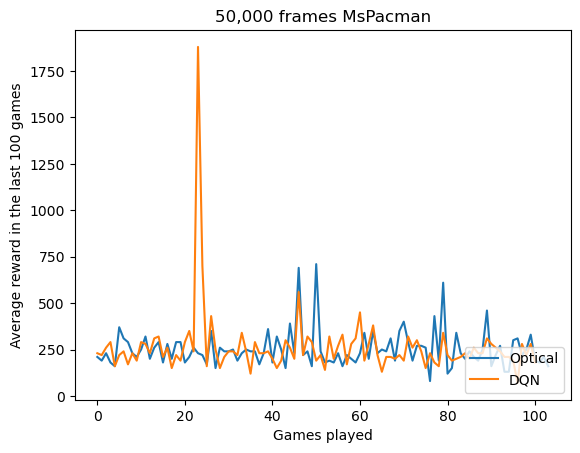

In [230]:
plt.plot(rewards2_pacman_opt)
plt.plot(rewards2_pacman)
plt.title('50,000 frames MsPacman')
plt.xlabel('Games played')
plt.ylabel('Average reward in the last 100 games')
plt.legend(["Optical", "DQN"], loc ="lower right")
plt.show()

#### 2 millones

In [12]:
DEFAULT_ENV_NAME = "MsPacmanNoFrameskip-v4" 
MEAN_REWARD_BOUND = 1000.0        
MAX_FRAMES = 2_000_000

gamma = 0.99                   
batch_size = 32                
replay_size = 10_000            
learning_rate = 1e-4      
sync_target_frames = 1_000      
replay_start_size = 10_000      

eps_start=1.0
eps_decay=.9999975
eps_min=0.02

env = wrap_deepmind(make_atari(DEFAULT_ENV_NAME, 1000), optical=False)

np.random.seed(2109);
env.seed(2109);

In [13]:
rewards1_pacman = train_func(env, DEFAULT_ENV_NAME, False, MEAN_REWARD_BOUND, MAX_FRAMES, gamma, batch_size, replay_size, learning_rate, sync_target_frames, replay_start_size, eps_start, eps_decay, eps_min, device)

  5%|███▌                                                                   | 100008/1999999 [16:00<6:25:52, 82.07it/s]

100000:  199 games, mean reward 257.800, (eps 0.78), time 0:15:59.301825


 10%|███████                                                                | 200013/1999999 [34:17<5:19:03, 94.03it/s]

200000:  386 games, mean reward 373.200, (eps 0.61), time 0:34:16.059871


 15%|██████████▋                                                            | 300013/1999999 [53:22<5:23:30, 87.58it/s]

300000:  576 games, mean reward 452.400, (eps 0.47), time 0:53:18.640298


 20%|█████████████▊                                                       | 400016/1999999 [1:12:49<4:53:40, 90.80it/s]

400000:  758 games, mean reward 516.400, (eps 0.37), time 1:12:46.300310


 25%|█████████████████▎                                                   | 500016/1999999 [1:31:47<4:36:37, 90.37it/s]

500000:  940 games, mean reward 543.400, (eps 0.29), time 1:31:46.547198


 30%|████████████████████▋                                                | 600014/1999999 [1:50:32<4:18:01, 90.43it/s]

600000:  1103 games, mean reward 639.300, (eps 0.22), time 1:50:29.066373


 35%|████████████████████████▏                                            | 700008/1999999 [2:09:17<4:00:33, 90.07it/s]

700000:  1275 games, mean reward 671.300, (eps 0.17), time 2:09:16.306846


 40%|███████████████████████████▌                                         | 800015/1999999 [2:28:06<3:46:08, 88.44it/s]

800000:  1442 games, mean reward 714.000, (eps 0.14), time 2:28:02.992211


 45%|███████████████████████████████                                      | 900009/1999999 [2:47:04<3:30:27, 87.11it/s]

900000:  1621 games, mean reward 613.100, (eps 0.11), time 2:47:01.553081


 50%|██████████████████████████████████                                  | 1000013/1999999 [3:06:06<3:08:50, 88.25it/s]

1000000:  1798 games, mean reward 621.700, (eps 0.08), time 3:06:05.376739


 55%|█████████████████████████████████████▍                              | 1100014/1999999 [3:25:13<2:49:16, 88.61it/s]

1100000:  1967 games, mean reward 679.500, (eps 0.06), time 3:25:13.102043


 60%|████████████████████████████████████████▊                           | 1200018/1999999 [3:44:19<2:30:34, 88.55it/s]

1200000:  2138 games, mean reward 654.000, (eps 0.05), time 3:44:15.950993


 65%|████████████████████████████████████████████▏                       | 1300016/1999999 [4:03:22<2:21:01, 82.72it/s]

1300000:  2312 games, mean reward 609.200, (eps 0.04), time 4:03:18.453381


 70%|███████████████████████████████████████████████▌                    | 1400010/1999999 [4:22:22<1:55:09, 86.83it/s]

1400000:  2484 games, mean reward 616.600, (eps 0.03), time 4:22:20.622086


 75%|███████████████████████████████████████████████████                 | 1500016/1999999 [4:41:25<1:34:34, 88.11it/s]

1500000:  2663 games, mean reward 530.200, (eps 0.02), time 4:41:21.956549


 80%|██████████████████████████████████████████████████████▍             | 1600010/1999999 [5:00:24<1:16:14, 87.44it/s]

1600000:  2839 games, mean reward 606.000, (eps 0.02), time 5:00:23.425314


 85%|███████████████████████████████████████████████████████████▌          | 1700014/1999999 [5:19:19<58:14, 85.85it/s]

1700000:  3009 games, mean reward 611.700, (eps 0.02), time 5:19:13.183766


 90%|███████████████████████████████████████████████████████████████       | 1800006/1999999 [5:38:12<37:55, 87.87it/s]

1800000:  3184 games, mean reward 665.900, (eps 0.02), time 5:38:09.467316


 95%|██████████████████████████████████████████████████████████████████▌   | 1900016/1999999 [5:57:15<18:55, 88.09it/s]

1900000:  3367 games, mean reward 519.200, (eps 0.02), time 5:57:15.033511


100%|██████████████████████████████████████████████████████████████████████| 1999999/1999999 [6:16:03<00:00, 88.64it/s]

Traning finished
1999999:  3542 games, mean reward 518.900, (eps 0.02), time 6:16:02.086013


In [53]:
# Video de una corrida de MsPacman.
np.random.seed(2109)
env.seed(2109)
make_video(DEFAULT_ENV_NAME, False)

61, reward 10.0
64, reward 10.0
68, reward 10.0
71, reward 10.0
75, reward 10.0
78, reward 10.0
81, reward 10.0
Total reward: 70.00


In [54]:
# Obtiene una muestra de partidas con la red entrenada.
np.random.seed(2109)
env.seed(2109)
sample_Pacman = sample(DEFAULT_ENV_NAME, 20, False)
sample_Pacman

array([70., 70., 70., 70., 70., 70., 70., 70., 70., 70., 70., 70., 70.,
       70., 70., 70., 70., 70., 70., 70.])

#### Optical Flow

In [22]:
DEFAULT_ENV_NAME = "MsPacmanNoFrameskip-v4" 
MEAN_REWARD_BOUND = 1000.0        
MAX_FRAMES = 2_000_000

gamma = 0.99                   
batch_size = 32                
replay_size = 10_000            
learning_rate = 1e-4      
sync_target_frames = 1_000      
replay_start_size = 10_000      

eps_start=1.0
eps_decay=.9999975
eps_min=0.02

env = wrap_deepmind(make_atari(DEFAULT_ENV_NAME, 1000), optical=True)

np.random.seed(2109);
env.seed(2109);

In [23]:
rewards1_pacman_opt = train_func(env, DEFAULT_ENV_NAME, True, MEAN_REWARD_BOUND, MAX_FRAMES, gamma, batch_size, replay_size, learning_rate, sync_target_frames, replay_start_size, eps_start, eps_decay, eps_min, device)

  5%|███▌                                                                  | 100008/1999999 [22:22<10:04:27, 52.39it/s]

100000:  200 games, mean reward 287.400, (eps 0.78), time 0:22:18.731928


 10%|███████                                                                | 200012/1999999 [47:39<7:18:31, 68.41it/s]

200000:  405 games, mean reward 285.800, (eps 0.61), time 0:47:32.866177


 15%|██████████▎                                                          | 300008/1999999 [1:14:23<7:20:12, 64.36it/s]

300000:  616 games, mean reward 262.800, (eps 0.47), time 1:14:12.337063


 20%|█████████████▊                                                       | 400007/1999999 [1:41:30<6:53:42, 64.46it/s]

400000:  827 games, mean reward 270.200, (eps 0.37), time 1:41:19.917668


 25%|█████████████████▎                                                   | 500010/1999999 [2:08:30<6:42:07, 62.17it/s]

500000:  1038 games, mean reward 356.100, (eps 0.29), time 2:08:25.829965


 30%|████████████████████▋                                                | 600008/1999999 [2:35:06<6:22:12, 61.05it/s]

600000:  1240 games, mean reward 354.900, (eps 0.22), time 2:35:00.401395


 35%|████████████████████████▏                                            | 700012/1999999 [3:02:14<5:48:34, 62.16it/s]

700000:  1438 games, mean reward 351.800, (eps 0.17), time 3:02:13.203109


 40%|███████████████████████████▌                                         | 800008/1999999 [3:30:36<5:34:44, 59.75it/s]

800000:  1633 games, mean reward 325.800, (eps 0.14), time 3:30:32.060151


 45%|██████████████████████████████▌                                     | 900002/1999999 [4:05:54<29:40:49, 10.29it/s]

900000:  1822 games, mean reward 348.300, (eps 0.11), time 4:05:34.416074


 50%|██████████████████████████████████                                  | 1000006/1999999 [4:36:22<4:53:23, 56.81it/s]

1000000:  2012 games, mean reward 305.100, (eps 0.08), time 4:36:22.481307


 55%|█████████████████████████████████████▍                              | 1100011/1999999 [5:04:52<4:15:09, 58.78it/s]

1100000:  2190 games, mean reward 361.800, (eps 0.06), time 5:04:44.157322


 60%|████████████████████████████████████████▊                           | 1200012/1999999 [5:33:21<3:48:39, 58.31it/s]

1200000:  2364 games, mean reward 453.800, (eps 0.05), time 5:33:18.683671


 65%|████████████████████████████████████████████▏                       | 1300010/1999999 [6:01:57<3:22:54, 57.49it/s]

1300000:  2537 games, mean reward 473.200, (eps 0.04), time 6:01:53.940411


 70%|███████████████████████████████████████████████▌                    | 1400011/1999999 [6:30:36<2:50:08, 58.77it/s]

1400000:  2704 games, mean reward 560.300, (eps 0.03), time 6:30:25.185342


 75%|███████████████████████████████████████████████████                 | 1500007/1999999 [6:59:28<2:28:30, 56.11it/s]

1500000:  2874 games, mean reward 539.900, (eps 0.02), time 6:59:20.838997


 80%|██████████████████████████████████████████████████████▍             | 1600007/1999999 [7:28:22<1:54:23, 58.28it/s]

1600000:  3035 games, mean reward 655.600, (eps 0.02), time 7:28:15.949624


 85%|█████████████████████████████████████████████████████████▊          | 1700005/1999999 [7:57:21<1:24:33, 59.13it/s]

1700000:  3185 games, mean reward 721.200, (eps 0.02), time 7:57:15.027035


 90%|███████████████████████████████████████████████████████████████       | 1800008/1999999 [8:26:24<57:32, 57.93it/s]

1800000:  3347 games, mean reward 587.800, (eps 0.02), time 8:26:23.083194


 95%|██████████████████████████████████████████████████████████████████▌   | 1900011/1999999 [8:55:32<30:02, 55.49it/s]

1900000:  3512 games, mean reward 576.000, (eps 0.02), time 8:55:26.158253


100%|██████████████████████████████████████████████████████████████████████| 1999999/1999999 [9:24:49<00:00, 59.02it/s]


Traning finished
1999999:  3670 games, mean reward 601.400, (eps 0.02), time 9:24:48.012695


In [37]:
# Video MsPacman
make_video(DEFAULT_ENV_NAME, True)

63, reward 10.0
69, reward 10.0
72, reward 10.0
76, reward 10.0
79, reward 10.0
90, reward 10.0
94, reward 10.0
97, reward 10.0
106, reward 10.0
114, reward 10.0
117, reward 10.0
124, reward 10.0
128, reward 10.0
131, reward 10.0
134, reward 10.0
139, reward 10.0
142, reward 10.0
151, reward 10.0
155, reward 10.0
158, reward 10.0
163, reward 50.0
165, reward 10.0
186, reward 200.0
193, reward 10.0
253, reward 400.0
258, reward 10.0
264, reward 10.0
269, reward 10.0
272, reward 10.0
281, reward 10.0
285, reward 10.0
288, reward 10.0
292, reward 10.0
298, reward 10.0
302, reward 10.0
305, reward 50.0
332, reward 10.0
335, reward 10.0
339, reward 10.0
350, reward 10.0
354, reward 10.0
357, reward 10.0
360, reward 10.0
374, reward 10.0
381, reward 10.0
384, reward 10.0
425, reward 10.0
447, reward 10.0
453, reward 10.0
455, reward 10.0
458, reward 10.0
463, reward 10.0
472, reward 10.0
476, reward 10.0
481, reward 10.0
539, reward 10.0
542, reward 10.0
554, reward 10.0
557, reward 10.0
561

In [32]:
np.random.seed(2109)
env.seed(2109)
sample_Pacman_Opt = sample(DEFAULT_ENV_NAME, 20, True)
sample_Pacman_Opt

array([1280.,  270., 1280.,  470.,  470., 1280.,  270.,  270., 1280.,
        470., 1280., 1280.,  520.,  270.,  270., 1280.,  520.,  520.,
       1280., 1280.])

In [242]:
np.mean(sample_Pacman_Opt)

792.0

In [35]:
ranksums(sample_Pacman, sample_Pacman_Opt)

RanksumsResult(statistic=-5.410017808004594, pvalue=6.301848221392269e-08)

Vemos que el p-value es menor a 0.5, por lo que se rechaza la H0: Los datos vienen de la misma distribución. Se acepta H1: Las distribuciones son distintas.

En este caso el promedio de DQN es 70 y el método con flujo óptico es de 792.

In [231]:
cumsum_opt = np.cumsum(np.insert(rewards1_pacman_opt, 0, 0)) 
opt_vec = (cumsum_opt[100:] - cumsum_opt[:-100]) / 100

In [232]:
cumsum = np.cumsum(np.insert(rewards1_pacman, 0, 0)) 
vec = (cumsum[100:] - cumsum[:-100]) / 100

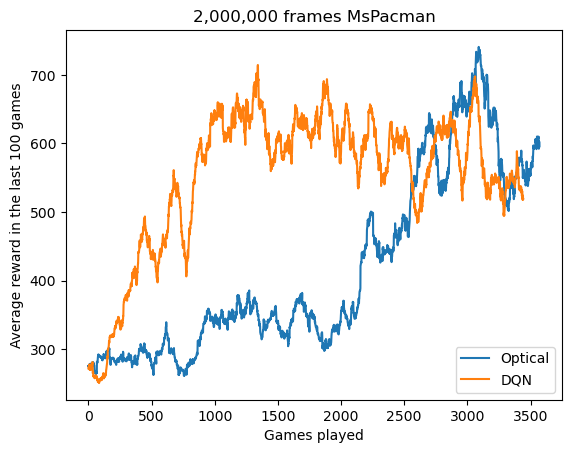

In [233]:
plt.plot(opt_vec)
plt.plot(vec)
plt.title('2,000,000 frames MsPacman')
plt.xlabel('Games played')
plt.ylabel('Average reward in the last 100 games')
plt.legend(["Optical", "DQN"], loc ="lower right")
plt.show()

### BREAKOUT

In [173]:
DEFAULT_ENV_NAME = "BreakoutNoFrameskip-v4" 
MEAN_REWARD_BOUND = 100.0        
MAX_FRAMES = 1_500_000

gamma = 0.99                   
batch_size = 32                
replay_size = 10_000            
learning_rate = 1e-4       
sync_target_frames = 1_000      
replay_start_size = 10_000      

eps_start=1.0
eps_decay=.9999975
eps_min=0.1

env = wrap_deepmind(make_atari(DEFAULT_ENV_NAME, 1000), optical=False)

np.random.seed(2109);
env.seed(2109);

In [174]:
rewards1_breakout = train_func(env, DEFAULT_ENV_NAME, False, MEAN_REWARD_BOUND, MAX_FRAMES, gamma, batch_size, replay_size, learning_rate, sync_target_frames, replay_start_size, eps_start, eps_decay, eps_min, device)

  5%|███▌                                                                    | 75014/1499999 [11:34<4:27:03, 88.93it/s]

75000:  403 games, mean reward 1.320, (eps 0.83), time 0:11:30.870437


 10%|███████                                                                | 150011/1499999 [25:36<4:03:24, 92.44it/s]

150000:  813 games, mean reward 1.040, (eps 0.69), time 0:25:35.448142


 15%|██████████▋                                                            | 225010/1499999 [39:13<4:30:13, 78.64it/s]

225000:  1221 games, mean reward 1.450, (eps 0.57), time 0:39:12.893072


 20%|██████████████▏                                                        | 300020/1499999 [52:36<3:24:16, 97.91it/s]

300000:  1629 games, mean reward 1.160, (eps 0.47), time 0:52:35.454975


 25%|█████████████████▎                                                   | 375020/1499999 [1:05:54<3:18:03, 94.66it/s]

375000:  2026 games, mean reward 1.150, (eps 0.39), time 1:05:54.305835


 30%|████████████████████▋                                                | 450010/1499999 [1:20:06<3:20:11, 87.41it/s]

450000:  2395 games, mean reward 1.600, (eps 0.32), time 1:20:04.809478


 35%|████████████████████████▏                                            | 525017/1499999 [1:34:31<3:00:31, 90.01it/s]

525000:  2764 games, mean reward 1.510, (eps 0.27), time 1:34:30.423756


 40%|███████████████████████████▌                                         | 600012/1499999 [1:49:14<3:02:26, 82.22it/s]

600000:  3123 games, mean reward 1.230, (eps 0.22), time 1:49:14.659833


 45%|███████████████████████████████                                      | 675017/1499999 [2:03:41<2:29:49, 91.77it/s]

675000:  3468 games, mean reward 1.240, (eps 0.18), time 2:03:41.038009


 50%|██████████████████████████████████▌                                  | 750017/1499999 [2:18:12<2:18:17, 90.39it/s]

750000:  3825 games, mean reward 1.540, (eps 0.15), time 2:18:10.224532


 55%|█████████████████████████████████████▉                               | 825018/1499999 [2:32:31<2:14:24, 83.70it/s]

825000:  4129 games, mean reward 1.450, (eps 0.13), time 2:32:30.423527


 60%|█████████████████████████████████████████▍                           | 900017/1499999 [2:46:45<1:52:31, 88.87it/s]

900000:  4451 games, mean reward 1.570, (eps 0.11), time 2:46:44.227086


 65%|████████████████████████████████████████████▊                        | 975014/1499999 [3:00:54<1:38:51, 88.51it/s]

975000:  4771 games, mean reward 1.410, (eps 0.10), time 3:00:53.612860


 70%|███████████████████████████████████████████████▌                    | 1050011/1499999 [3:15:00<1:24:17, 88.97it/s]

1050000:  5087 games, mean reward 1.190, (eps 0.10), time 3:14:59.739079


 75%|███████████████████████████████████████████████████                 | 1125017/1499999 [3:29:06<1:10:13, 89.00it/s]

1125000:  5405 games, mean reward 1.560, (eps 0.10), time 3:29:05.565307


 80%|████████████████████████████████████████████████████████              | 1200014/1499999 [3:43:08<56:33, 88.41it/s]

1200000:  5699 games, mean reward 1.410, (eps 0.10), time 3:43:07.682746


 85%|███████████████████████████████████████████████████████████▌          | 1275014/1499999 [3:57:12<41:47, 89.71it/s]

1275000:  6015 games, mean reward 1.440, (eps 0.10), time 3:57:10.324094


 90%|███████████████████████████████████████████████████████████████       | 1350010/1499999 [4:11:17<27:17, 91.59it/s]

1350000:  6301 games, mean reward 1.480, (eps 0.10), time 4:11:16.587377


 95%|██████████████████████████████████████████████████████████████████▌   | 1425013/1499999 [4:25:19<13:21, 93.62it/s]

1425000:  6593 games, mean reward 1.820, (eps 0.10), time 4:25:18.186165


100%|██████████████████████████████████████████████████████████████████████| 1499999/1499999 [4:39:19<00:00, 89.50it/s]

Traning finished
1499999:  6881 games, mean reward 1.610, (eps 0.10), time 4:39:18.332338


In [179]:
# Video Breakout
make_video(DEFAULT_ENV_NAME, False)

Total reward: 0.00


In [183]:
np.random.seed(2109)
env.seed(2109)
sample_breakout = sample(DEFAULT_ENV_NAME, 20, False)
sample_breakout

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0.])

#### Optical Flow

In [184]:
DEFAULT_ENV_NAME = "BreakoutNoFrameskip-v4" 
MEAN_REWARD_BOUND = 100.0        
MAX_FRAMES = 1_500_000

gamma = 0.99                   
batch_size = 32                
replay_size = 10_000            
learning_rate = 1e-4       
sync_target_frames = 1_000      
replay_start_size = 10_000      

eps_start=1.0
eps_decay=.9999975
eps_min=0.1

env = wrap_deepmind(make_atari(DEFAULT_ENV_NAME, 1000), optical=True)

np.random.seed(2109);
env.seed(2109);

In [185]:
rewards1_breakout_opt = train_func(env, DEFAULT_ENV_NAME, True, MEAN_REWARD_BOUND, MAX_FRAMES, gamma, batch_size, replay_size, learning_rate, sync_target_frames, replay_start_size, eps_start, eps_decay, eps_min, device)

  5%|███▌                                                                    | 75014/1499999 [16:50<6:05:39, 64.95it/s]

75000:  409 games, mean reward 1.150, (eps 0.83), time 0:16:48.804932


 10%|███████                                                                | 150009/1499999 [36:28<5:46:12, 64.99it/s]

150000:  821 games, mean reward 1.270, (eps 0.69), time 0:36:26.185082


 15%|██████████▋                                                            | 225006/1499999 [56:23<5:42:08, 62.11it/s]

225000:  1236 games, mean reward 1.220, (eps 0.57), time 0:56:22.403565


 20%|█████████████▊                                                       | 300006/1499999 [1:16:43<5:23:44, 61.78it/s]

300000:  1644 games, mean reward 1.020, (eps 0.47), time 1:16:41.960786


 25%|█████████████████▎                                                   | 375009/1499999 [1:37:24<5:18:04, 58.95it/s]

375000:  2048 games, mean reward 0.740, (eps 0.39), time 1:37:23.642974


 30%|████████████████████▋                                                | 450008/1499999 [1:58:26<4:59:15, 58.48it/s]

450000:  2450 games, mean reward 0.970, (eps 0.32), time 1:58:25.310966


 35%|████████████████████████▏                                            | 525006/1499999 [2:19:43<4:33:52, 59.33it/s]

525000:  2821 games, mean reward 1.030, (eps 0.27), time 2:19:43.097588


 40%|███████████████████████████▌                                         | 600009/1499999 [2:41:17<4:30:32, 55.44it/s]

600000:  3180 games, mean reward 1.190, (eps 0.22), time 2:41:16.404434


 45%|███████████████████████████████                                      | 675011/1499999 [3:03:02<3:50:17, 59.71it/s]

675000:  3512 games, mean reward 1.330, (eps 0.18), time 3:02:59.586809


 50%|██████████████████████████████████▌                                  | 750012/1499999 [3:24:51<3:31:14, 59.17it/s]

750000:  3832 games, mean reward 1.400, (eps 0.15), time 3:24:50.689469


 55%|█████████████████████████████████████▉                               | 825006/1499999 [3:46:51<3:15:20, 57.59it/s]

825000:  4148 games, mean reward 1.380, (eps 0.13), time 3:46:49.056415


 60%|█████████████████████████████████████████▍                           | 900012/1499999 [4:08:47<2:56:48, 56.56it/s]

900000:  4434 games, mean reward 1.710, (eps 0.11), time 4:08:42.358749


 65%|████████████████████████████████████████████▊                        | 975007/1499999 [4:31:45<2:43:11, 53.61it/s]

975000:  4698 games, mean reward 1.700, (eps 0.10), time 4:31:37.966415


 70%|███████████████████████████████████████████████▌                    | 1050004/1499999 [4:54:57<2:23:43, 52.18it/s]

1050000:  4960 games, mean reward 1.550, (eps 0.10), time 4:54:54.943935


 75%|███████████████████████████████████████████████████                 | 1125011/1499999 [5:18:21<1:54:46, 54.46it/s]

1125000:  5242 games, mean reward 1.660, (eps 0.10), time 5:18:14.995640


 80%|██████████████████████████████████████████████████████▍             | 1200006/1499999 [5:42:09<1:32:12, 54.23it/s]

1200000:  5497 games, mean reward 2.110, (eps 0.10), time 5:42:05.925808


 85%|█████████████████████████████████████████████████████████▊          | 1275007/1499999 [6:05:03<1:08:22, 54.85it/s]

1275000:  5761 games, mean reward 1.530, (eps 0.10), time 6:04:57.562735


 90%|███████████████████████████████████████████████████████████████       | 1350009/1499999 [6:27:45<43:36, 57.32it/s]

1350000:  6029 games, mean reward 1.560, (eps 0.10), time 6:27:43.952228


 95%|██████████████████████████████████████████████████████████████████▌   | 1425009/1499999 [6:51:36<24:18, 51.40it/s]

1425000:  6330 games, mean reward 1.950, (eps 0.10), time 6:51:34.297069


100%|██████████████████████████████████████████████████████████████████████| 1499999/1499999 [7:17:17<00:00, 57.17it/s]


Traning finished
1499999:  6644 games, mean reward 1.920, (eps 0.10), time 7:17:15.938740


In [186]:
# Video Breakout
np.random.seed(2109)
env.seed(2109)
make_video(DEFAULT_ENV_NAME, True)

70, reward 1.0
Total reward: 1.00


In [187]:
np.random.seed(2109)
env.seed(2109)
sample_breakout_opt = sample(DEFAULT_ENV_NAME, 20, True)
sample_breakout_opt

array([5., 0., 1., 0., 5., 0., 1., 0., 1., 1., 0., 1., 1., 0., 0., 1., 5.,
       1., 1., 1.])

In [243]:
np.mean(sample_breakout_opt)

1.25

In [188]:
ranksums(sample_breakout, sample_breakout_opt)

RanksumsResult(statistic=-3.5165115752029856, pvalue=0.0004372575927067331)

Vemos que el p-value es menor a 0.5, de modo que podemos asumir que las distribuciones diferentes y ya que el modelo con flujo óptico obtiene mejores resultados, también asumimos que es el mejor de ambos.

In [234]:
cumsum_opt = np.cumsum(np.insert(rewards1_breakout_opt, 0, 0)) 
opt_vec = (cumsum_opt[100:] - cumsum_opt[:-100]) / 100

In [235]:
cumsum = np.cumsum(np.insert(rewards1_breakout, 0, 0)) 
vec = (cumsum[100:] - cumsum[:-100]) / 100

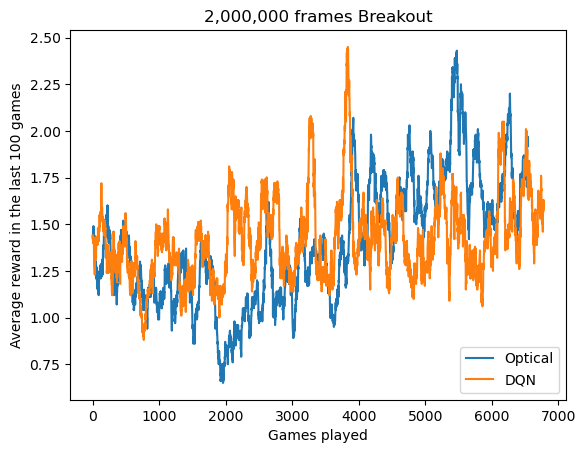

In [236]:
plt.plot(opt_vec)
plt.plot(vec)
plt.title('1,500,000 frames Breakout')
plt.xlabel('Games played')
plt.ylabel('Average reward in the last 100 games')
plt.legend(["Optical", "DQN"], loc ="lower right")
plt.show()

### SPACE INVADERS

In [164]:
DEFAULT_ENV_NAME = "SpaceInvadersNoFrameskip-v4" 
MEAN_REWARD_BOUND = 2000.0        
MAX_FRAMES = 2_000_000

gamma = 0.99                   
batch_size = 32                
replay_size = 10_000            
learning_rate = 1e-4       
sync_target_frames = 1_000      
replay_start_size = 10_000      

eps_start=1.0
eps_decay=.9999975
eps_min=0.1

env = wrap_deepmind(make_atari(DEFAULT_ENV_NAME, 1000), optical=False)

np.random.seed(2109);
env.seed(2109);

In [161]:
rewards1_invaders = train_func(env, DEFAULT_ENV_NAME, False, MEAN_REWARD_BOUND, MAX_FRAMES, gamma, batch_size, replay_size, learning_rate, sync_target_frames, replay_start_size, eps_start, eps_decay, eps_min, device)

  5%|███▌                                                                  | 100014/1999999 [15:28<5:12:21, 101.38it/s]

100000:  201 games, mean reward 142.150, (eps 0.78), time 0:15:23.819900


 10%|███████                                                                | 200016/1999999 [33:07<5:03:32, 98.83it/s]

200000:  396 games, mean reward 147.450, (eps 0.61), time 0:33:03.185206


 15%|██████████▋                                                            | 300017/1999999 [50:24<5:02:53, 93.54it/s]

300000:  584 games, mean reward 176.200, (eps 0.47), time 0:50:21.196834


 20%|█████████████▊                                                       | 400012/1999999 [1:08:03<4:38:47, 95.65it/s]

400000:  762 games, mean reward 169.400, (eps 0.37), time 1:08:02.122952


 25%|█████████████████▎                                                   | 500012/1999999 [1:26:01<4:28:04, 93.25it/s]

500000:  930 games, mean reward 191.950, (eps 0.29), time 1:25:59.983299


 30%|████████████████████▋                                                | 600016/1999999 [1:44:13<4:13:30, 92.04it/s]

600000:  1103 games, mean reward 178.000, (eps 0.22), time 1:44:12.703207


 35%|████████████████████████▏                                            | 700010/1999999 [2:02:38<3:56:40, 91.55it/s]

700000:  1271 games, mean reward 171.250, (eps 0.17), time 2:02:38.158585


 40%|███████████████████████████▌                                         | 800016/1999999 [2:21:13<3:39:20, 91.18it/s]

800000:  1432 games, mean reward 196.850, (eps 0.14), time 2:21:07.047669


 45%|███████████████████████████████                                      | 900016/1999999 [2:39:57<3:20:33, 91.41it/s]

900000:  1594 games, mean reward 202.950, (eps 0.11), time 2:39:54.083398


 50%|██████████████████████████████████                                  | 1000006/1999999 [2:59:31<3:00:40, 92.25it/s]

1000000:  1747 games, mean reward 220.400, (eps 0.10), time 2:59:26.900205


 55%|█████████████████████████████████████▍                              | 1100017/1999999 [3:18:03<2:44:51, 90.98it/s]

1100000:  1909 games, mean reward 205.650, (eps 0.10), time 3:17:59.062099


 60%|████████████████████████████████████████▊                           | 1200006/1999999 [3:36:29<2:26:58, 90.72it/s]

1200000:  2078 games, mean reward 185.300, (eps 0.10), time 3:36:28.143920


 65%|████████████████████████████████████████████▏                       | 1300012/1999999 [3:54:58<2:11:30, 88.72it/s]

1300000:  2238 games, mean reward 206.400, (eps 0.10), time 3:54:49.044749


 70%|███████████████████████████████████████████████▌                    | 1400009/1999999 [4:13:26<1:53:15, 88.29it/s]

1400000:  2393 games, mean reward 231.950, (eps 0.10), time 4:13:25.763219


 75%|███████████████████████████████████████████████████                 | 1500008/1999999 [4:31:53<1:33:55, 88.72it/s]

1500000:  2550 games, mean reward 222.050, (eps 0.10), time 4:31:52.354623


 80%|██████████████████████████████████████████████████████▍             | 1600008/1999999 [4:50:30<1:14:49, 89.10it/s]

1600000:  2702 games, mean reward 210.750, (eps 0.10), time 4:50:23.918163


 85%|███████████████████████████████████████████████████████████▌          | 1700018/1999999 [5:09:11<53:45, 92.99it/s]

1700000:  2866 games, mean reward 178.200, (eps 0.10), time 5:09:10.794276


 90%|███████████████████████████████████████████████████████████████       | 1800019/1999999 [5:27:59<37:31, 88.82it/s]

1800000:  3019 games, mean reward 207.050, (eps 0.10), time 5:27:58.016017


 95%|██████████████████████████████████████████████████████████████████▌   | 1900014/1999999 [5:46:18<19:06, 87.24it/s]

1900000:  3173 games, mean reward 235.550, (eps 0.10), time 5:46:16.567943


100%|██████████████████████████████████████████████████████████████████████| 1999999/1999999 [6:05:02<00:00, 91.31it/s]

Traning finished
1999999:  3324 games, mean reward 217.950, (eps 0.10), time 6:04:58.882216


In [165]:
# Video Space Invaders
make_video(DEFAULT_ENV_NAME, False)

93, reward 5.0
101, reward 10.0
113, reward 15.0
126, reward 20.0
142, reward 25.0
159, reward 30.0
494, reward 5.0
502, reward 10.0
512, reward 15.0
524, reward 20.0
538, reward 25.0
555, reward 30.0
660, reward 15.0
665, reward 5.0
672, reward 10.0
684, reward 20.0
698, reward 25.0
Total reward: 285.00


In [166]:
np.random.seed(2109)
env.seed(2109)
sample_invaders = sample(DEFAULT_ENV_NAME, 20, False)
sample_invaders

array([285., 285., 285., 285., 285., 285., 285., 285., 285., 285., 285.,
       285., 285., 285., 285., 285., 285., 285., 285., 285.])

#### Optical Flow

In [115]:
DEFAULT_ENV_NAME = "SpaceInvadersNoFrameskip-v4" 
MEAN_REWARD_BOUND = 2_000.0        
MAX_FRAMES = 2_000_000

gamma = 0.99                   
batch_size = 32                
replay_size = 10_000            
learning_rate = 1e-4  
sync_target_frames = 1_000      
replay_start_size = 10_000      

eps_start = 1.0
eps_decay = 0.9999975
eps_min = 0.02

env = wrap_deepmind(make_atari(DEFAULT_ENV_NAME, 1000), optical=True)

np.random.seed(2109);
env.seed(2109);

In [116]:
rewards1_invaders_Opt = train_func(env, DEFAULT_ENV_NAME, True, MEAN_REWARD_BOUND, MAX_FRAMES, gamma, batch_size, replay_size, learning_rate, sync_target_frames, replay_start_size, eps_start, eps_decay, eps_min, device)

  5%|███▌                                                                   | 100008/1999999 [23:12<8:07:49, 64.91it/s]

100000:  191 games, mean reward 154.450, (eps 0.78), time 0:23:01.252446


 10%|███████                                                                | 200007/1999999 [50:01<7:59:41, 62.54it/s]

200000:  389 games, mean reward 132.600, (eps 0.61), time 0:49:46.877463


 15%|██████████▎                                                          | 300011/1999999 [1:17:31<8:07:06, 58.17it/s]

300000:  586 games, mean reward 168.200, (eps 0.47), time 1:17:19.935033


 20%|█████████████▊                                                       | 400006/1999999 [1:45:05<7:21:36, 60.38it/s]

400000:  783 games, mean reward 155.400, (eps 0.37), time 1:45:04.286527


 25%|█████████████████▎                                                   | 500006/1999999 [2:12:22<6:52:56, 60.54it/s]

500000:  973 games, mean reward 153.150, (eps 0.29), time 2:12:17.640237


 30%|████████████████████▋                                                | 600010/1999999 [2:40:14<6:38:17, 58.58it/s]

600000:  1169 games, mean reward 149.100, (eps 0.22), time 2:40:12.646466


 35%|████████████████████████▏                                            | 700007/1999999 [3:08:30<6:09:07, 58.70it/s]

700000:  1360 games, mean reward 157.600, (eps 0.17), time 3:08:22.574400


 40%|███████████████████████████▌                                         | 800010/1999999 [3:37:07<5:49:26, 57.23it/s]

800000:  1554 games, mean reward 162.800, (eps 0.14), time 3:37:07.355290


 45%|███████████████████████████████                                      | 900007/1999999 [4:06:04<5:32:56, 55.06it/s]

900000:  1746 games, mean reward 156.900, (eps 0.11), time 4:06:00.676691


 50%|██████████████████████████████████                                  | 1000007/1999999 [4:35:07<4:51:03, 57.26it/s]

1000000:  1940 games, mean reward 157.300, (eps 0.08), time 4:34:58.378983


 55%|█████████████████████████████████████▍                              | 1100006/1999999 [5:04:06<4:25:23, 56.52it/s]

1100000:  2133 games, mean reward 182.200, (eps 0.06), time 5:04:02.954540


 60%|████████████████████████████████████████▊                           | 1200008/1999999 [5:33:40<3:52:02, 57.46it/s]

1200000:  2315 games, mean reward 180.500, (eps 0.05), time 5:33:39.985131


 65%|████████████████████████████████████████████▏                       | 1300008/1999999 [6:03:36<3:25:42, 56.71it/s]

1300000:  2506 games, mean reward 156.950, (eps 0.04), time 6:03:30.880067


 70%|███████████████████████████████████████████████▌                    | 1400007/1999999 [6:32:41<2:58:08, 56.13it/s]

1400000:  2689 games, mean reward 153.700, (eps 0.03), time 6:32:33.615784


 75%|███████████████████████████████████████████████████                 | 1500008/1999999 [7:01:48<2:26:13, 56.99it/s]

1500000:  2877 games, mean reward 177.650, (eps 0.02), time 7:01:44.604945


 80%|██████████████████████████████████████████████████████▍             | 1600010/1999999 [7:30:53<1:57:13, 56.87it/s]

1600000:  3072 games, mean reward 177.350, (eps 0.02), time 7:30:50.204407


 85%|█████████████████████████████████████████████████████████▊          | 1700007/1999999 [7:59:58<1:29:17, 56.00it/s]

1700000:  3263 games, mean reward 174.400, (eps 0.02), time 7:59:52.899171


 90%|███████████████████████████████████████████████████████████████       | 1800009/1999999 [8:29:03<58:50, 56.65it/s]

1800000:  3462 games, mean reward 127.850, (eps 0.02), time 8:29:01.891817


 95%|██████████████████████████████████████████████████████████████████▌   | 1900009/1999999 [8:58:07<29:51, 55.83it/s]

1900000:  3656 games, mean reward 193.950, (eps 0.02), time 8:58:03.760378


100%|██████████████████████████████████████████████████████████████████████| 1999999/1999999 [9:27:17<00:00, 58.76it/s]


Traning finished
1999999:  3848 games, mean reward 161.900, (eps 0.02), time 9:27:11.112592


In [117]:
# Video Space Invaders
make_video(DEFAULT_ENV_NAME, True)

70, reward 25.0
80, reward 5.0
102, reward 10.0
120, reward 30.0
148, reward 5.0
222, reward 5.0
231, reward 10.0
256, reward 15.0
285, reward 10.0
324, reward 20.0
368, reward 5.0
380, reward 10.0
495, reward 5.0
502, reward 10.0
536, reward 5.0
543, reward 10.0
552, reward 15.0
581, reward 15.0
655, reward 15.0
705, reward 15.0
740, reward 20.0
860, reward 25.0
877, reward 20.0
927, reward 25.0
937, reward 30.0
966, reward 20.0
Total reward: 380.00


In [168]:
np.random.seed(2109)
env.seed(2109)
sample_invaders_Opt = sample(DEFAULT_ENV_NAME, 20, True)
sample_invaders_Opt

array([165., 165., 120., 165., 120., 165., 380., 165., 165., 380., 120.,
       380., 380., 380., 380., 165., 120., 380., 165., 380.])

In [240]:
np.mean(sample_invaders_Opt)

242.0

In [169]:
ranksums(sample_invaders, sample_invaders_Opt)

RanksumsResult(statistic=1.0820035616009187, pvalue=0.27925094536873785)

Vemos que el p-value bi es menor a 0.5, así que no podemos asumir que las distribuciones son diferentes.

In [237]:
cumsum_opt = np.cumsum(np.insert(rewards1_invaders_Opt, 0, 0)) 
opt_vec = (cumsum_opt[100:] - cumsum_opt[:-100]) / 100

In [238]:
cumsum = np.cumsum(np.insert(rewards1_invaders, 0, 0)) 
vec = (cumsum[100:] - cumsum[:-100]) / 100

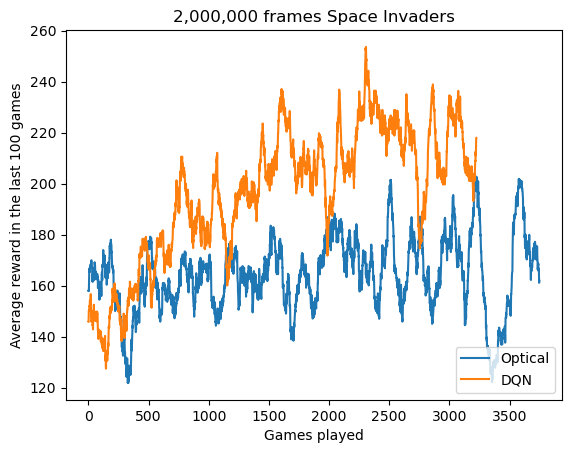

In [239]:
plt.plot(opt_vec)
plt.plot(vec)
plt.title('2,000,000 frames Space Invaders')
plt.xlabel('Games played')
plt.ylabel('Average reward in the last 100 games')
plt.legend(["Optical", "DQN"], loc ="lower right")
plt.show()

Vemos que a la hora de entrenar, en promedio, las recompensas eran mayores para DQN, pero a la hora de probar el modelo entrenado el modelo con flujo óptico obtiene el valor máximo de entre los 2, aunque también obtiene los valores mínimos.